In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

np.random.seed(42)
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [48]:
n_customers = 1000

def generate_customer_data():
    data = []

    segments = {
        'champions': {'weight': 0.15, 'recency': (1, 30), 'frequency': (10, 50), 'monetary': (2000, 10000)},
        'loyal': {'weight': 0.25, 'recency': (1, 60), 'frequency': (5, 20), 'monetary': (1000, 5000)},
        'at_risk': {'weight': 0.20, 'recency': (90, 365), 'frequency': (5, 25), 'monetary': (1500, 8000)},
        'new': {'weight': 0.40, 'recency': (1, 30), 'frequency': (1, 5), 'monetary': (100, 1000)}
    }

    customer_id = 1

    for archetype, params in segments.items():
        n_type = int(n_customers * params['weight'])

        for _ in range(n_type):
            recency = np.random.randint(params['recency'][0], params['recency'][1] + 1)
            frequency = np.random.randint(params['frequency'][0], params['frequency'][1] + 1)
            monetary = np.random.uniform(params['monetary'][0], params['monetary'][1])

            data.append({
                'customer_id': customer_id,
                'recency': recency,
                'frequency': frequency,
                'monetary': monetary,
                'segment': segments
            })
            customer_id += 1

    return pd.DataFrame(data)

df = generate_customer_data()
print(df.head(10))

   customer_id  recency  frequency     monetary  \
0            1        7         38  3467.478319   
1            2        8         30  3248.149124   
2            3       19         32  2464.668897   
3            4       24         45  3142.934543   
4            5        3         31  2451.292632   
5            6       24         39  3698.712885   
6            7       28         30  6939.852077   
7            8       26         31  2056.530442   
8            9       25         36  6894.823158   
9           10       10         37  9790.044151   

                                             segment  
0  {'champions': {'weight': 0.15, 'recency': (1, ...  
1  {'champions': {'weight': 0.15, 'recency': (1, ...  
2  {'champions': {'weight': 0.15, 'recency': (1, ...  
3  {'champions': {'weight': 0.15, 'recency': (1, ...  
4  {'champions': {'weight': 0.15, 'recency': (1, ...  
5  {'champions': {'weight': 0.15, 'recency': (1, ...  
6  {'champions': {'weight': 0.15, 'recency': (1, ... 

In [49]:
print("RFM Statistics:")
print(df[['recency', 'frequency', 'monetary']].describe())

print(f"\nsegment distribution:")
print(df['segment'].value_counts())

RFM Statistics:
           recency    frequency     monetary
count  1000.000000  1000.000000  1000.000000
mean     61.734000    11.818000  2838.961756
std      91.993337    10.767303  2530.352402
min       1.000000     1.000000   100.169560
25%      11.000000     4.000000   642.306827
50%      22.000000     8.000000  2192.363226
75%      47.500000    17.000000  4510.636708
max     358.000000    50.000000  9970.029598

segment distribution:
segment
{'champions': {'weight': 0.15, 'recency': (1, 30), 'frequency': (10, 50), 'monetary': (2000, 10000)}, 'loyal': {'weight': 0.25, 'recency': (1, 60), 'frequency': (5, 20), 'monetary': (1000, 5000)}, 'at_risk': {'weight': 0.2, 'recency': (90, 365), 'frequency': (5, 25), 'monetary': (1500, 8000)}, 'new': {'weight': 0.4, 'recency': (1, 30), 'frequency': (1, 5), 'monetary': (100, 1000)}}    1000
Name: count, dtype: int64


In [50]:
print(f"Total customers: {len(df):,}")
print(f"Date range: Last {df['recency'].max()} days")
print(f"Frequency range: {df['frequency'].min()}-{df['frequency'].max()} orders")
print(f"Monetary range: ${df['monetary'].min():.2f} - ${df['monetary'].max():,.2f}")

Total customers: 1,000
Date range: Last 358 days
Frequency range: 1-50 orders
Monetary range: $100.17 - $9,970.03


In [51]:
print(df.isnull().sum())

customer_id    0
recency        0
frequency      0
monetary       0
segment        0
dtype: int64


In [52]:
segment_counts = df['segment'].value_counts()
print(segment_counts)
for segment, count in segment_counts.items():
    print(f"{segment}: {count/len(df)*100:.1f}%")

segment
{'champions': {'weight': 0.15, 'recency': (1, 30), 'frequency': (10, 50), 'monetary': (2000, 10000)}, 'loyal': {'weight': 0.25, 'recency': (1, 60), 'frequency': (5, 20), 'monetary': (1000, 5000)}, 'at_risk': {'weight': 0.2, 'recency': (90, 365), 'frequency': (5, 25), 'monetary': (1500, 8000)}, 'new': {'weight': 0.4, 'recency': (1, 30), 'frequency': (1, 5), 'monetary': (100, 1000)}}    1000
Name: count, dtype: int64
{'champions': {'weight': 0.15, 'recency': (1, 30), 'frequency': (10, 50), 'monetary': (2000, 10000)}, 'loyal': {'weight': 0.25, 'recency': (1, 60), 'frequency': (5, 20), 'monetary': (1000, 5000)}, 'at_risk': {'weight': 0.2, 'recency': (90, 365), 'frequency': (5, 25), 'monetary': (1500, 8000)}, 'new': {'weight': 0.4, 'recency': (1, 30), 'frequency': (1, 5), 'monetary': (100, 1000)}}: 100.0%


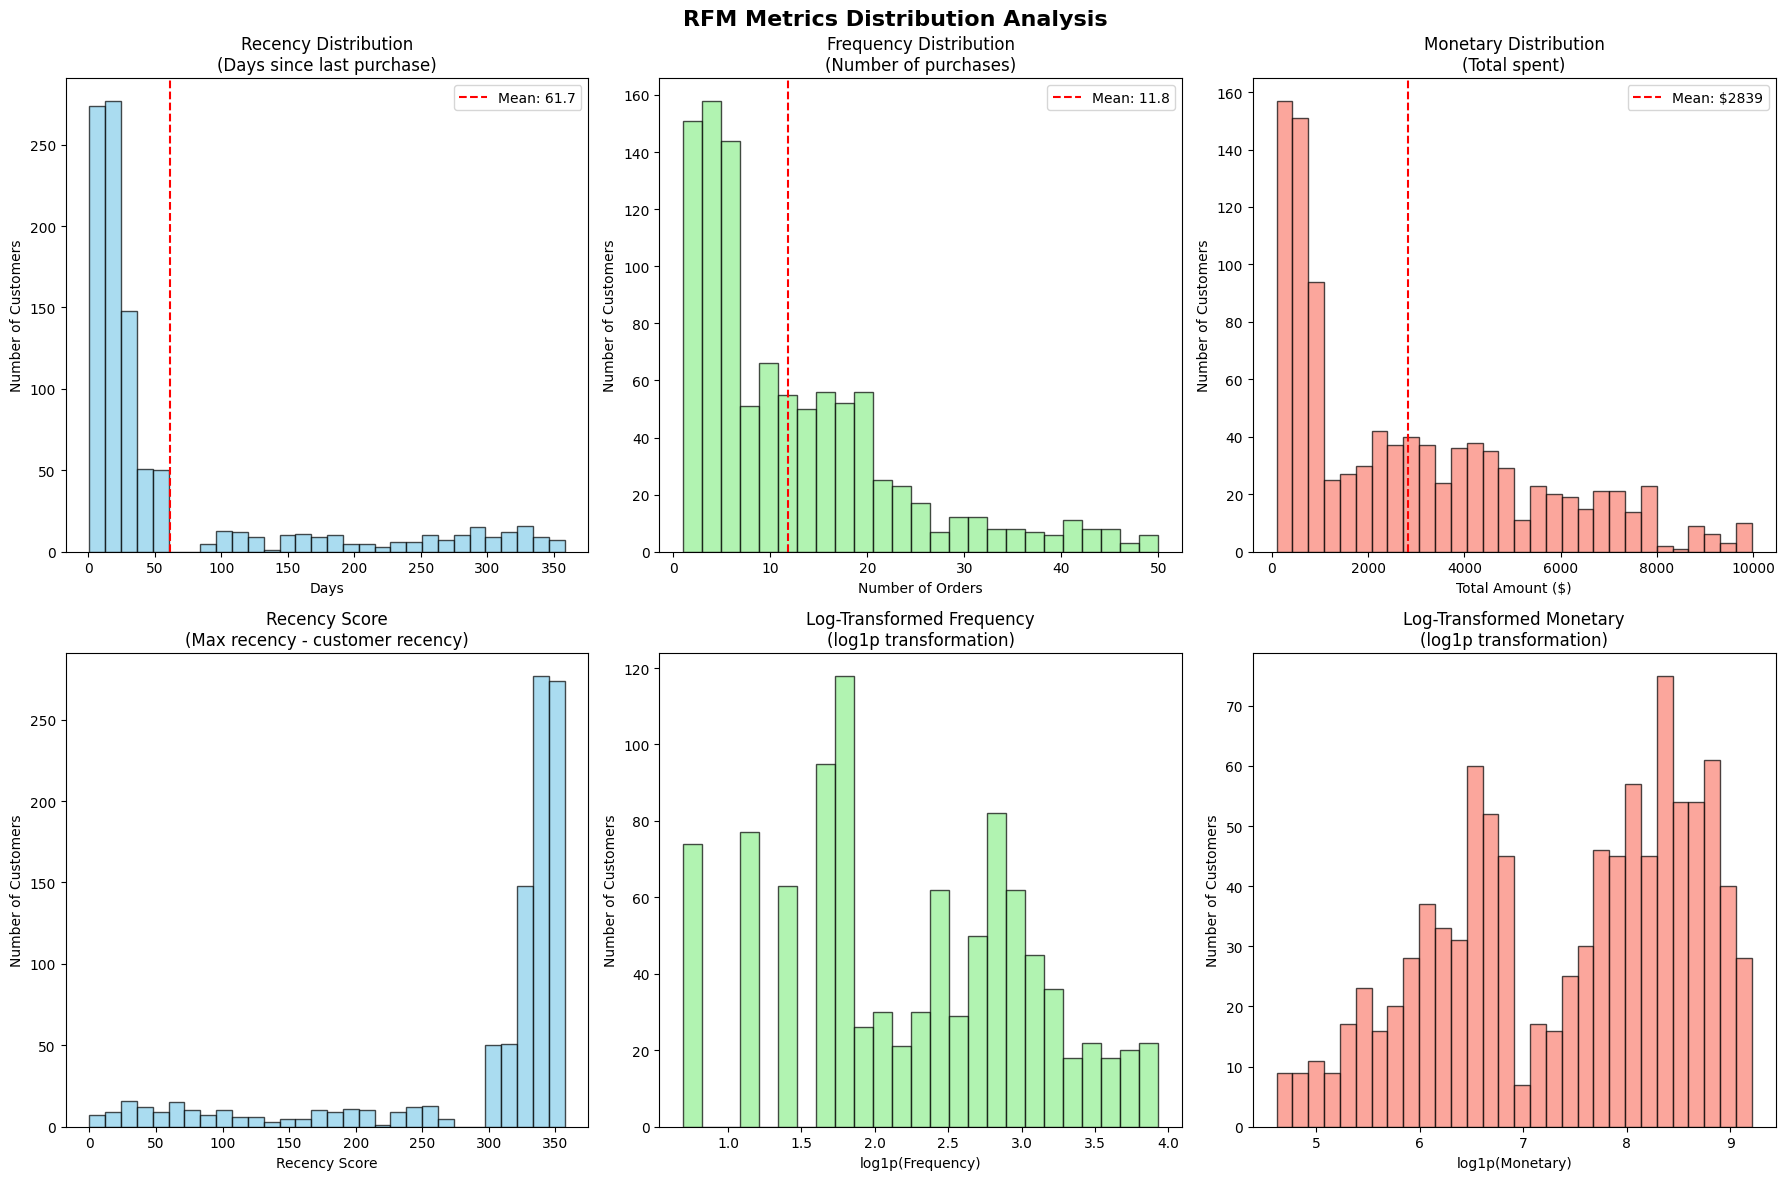

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('RFM Metrics Distribution Analysis', fontsize=16, fontweight='bold')

axes[0, 0].hist(df['recency'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Recency Distribution\n(Days since last purchase)')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].axvline(df['recency'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["recency"].mean():.1f}')
axes[0, 0].legend()


axes[0, 1].hist(df['frequency'], bins=25, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Frequency Distribution\n(Number of purchases)')
axes[0, 1].set_xlabel('Number of Orders')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].axvline(df['frequency'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["frequency"].mean():.1f}')
axes[0, 1].legend()

axes[0, 2].hist(df['monetary'], bins=30, alpha=0.7, color='salmon', edgecolor='black')
axes[0, 2].set_title('Monetary Distribution\n(Total spent)')
axes[0, 2].set_xlabel('Total Amount ($)')
axes[0, 2].set_ylabel('Number of Customers')
axes[0, 2].axvline(df['monetary'].mean(), color='red', linestyle='--',
                   label=f'Mean: ${df["monetary"].mean():.0f}')
axes[0, 2].legend()

axes[1, 0].hist(df['recency'].max() - df['recency'], bins=30,
                alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Recency Score\n(Max recency - customer recency)')
axes[1, 0].set_xlabel('Recency Score')
axes[1, 0].set_ylabel('Number of Customers')

axes[1, 1].hist(np.log1p(df['frequency']), bins=25,
                alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Log-Transformed Frequency\n(log1p transformation)')
axes[1, 1].set_xlabel('log1p(Frequency)')
axes[1, 1].set_ylabel('Number of Customers')

axes[1, 2].hist(np.log1p(df['monetary']), bins=30,
                alpha=0.7, color='salmon', edgecolor='black')
axes[1, 2].set_title('Log-Transformed Monetary\n(log1p transformation)')
axes[1, 2].set_xlabel('log1p(Monetary)')
axes[1, 2].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

In [54]:
def prepare_features(df):

    df_clean = df.copy()

    max_recency = df_clean['recency'].max()
    df_clean['recency'] = df_clean['recency'].fillna(max_recency + 30)

    df_clean['recency_score'] = df_clean['recency'].max() - df_clean['recency']
    df_clean['frequency_log'] = np.log1p(df_clean['frequency'])
    df_clean['monetary_log'] = np.log1p(df_clean['monetary'])

    features = ['recency_score', 'frequency_log', 'monetary_log']
    scaler = StandardScaler()
    X = scaler.fit_transform(df_clean[features])

    return X, df_clean, features

In [55]:
def find_best_clusters(X):

    best_k, best_score = 2, -1
    scores = {}

    for k in range(2, min(7, len(X))):
        try:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X)

            if len(np.unique(labels)) > 1:
                score = silhouette_score(X, labels)
                scores[k] = score
                if score > best_score:
                    best_score = score
                    best_k = k
        except Exception as e:
            print(f"Clustering failed for k={k}: {e}")

    return best_k, best_score, scores

In [56]:
X_scaled, df_processed, feature_names = prepare_features(df)

print(f"Original features: recency, frequency, monetary")
print(f"Engineered features: {feature_names}")
print(f"Scaled feature matrix shape: {X_scaled.shape}")

Original features: recency, frequency, monetary
Engineered features: ['recency_score', 'frequency_log', 'monetary_log']
Scaled feature matrix shape: (1000, 3)


In [57]:
feature_df = pd.DataFrame(df_processed[feature_names])
feature_df.head(10)

,recency_score,frequency_log,monetary_log
0,351,3.663562,8.151471
1,350,3.433987,8.086148
2,339,3.496508,7.810218
3,334,3.828641,8.053230
4,355,3.465736,7.804779
5,334,3.688879,8.216010
6,330,3.433987,8.845180
7,332,3.465736,7.629262
8,333,3.610918,8.838671
9,348,3.637586,9.189223


In [58]:
feature_df.describe()

,recency_score,frequency_log,monetary_log
count,1000.000000,1000.000000,1000.000000
mean,296.266000,2.207912,7.400865
std,91.993337,0.851474,1.181961
min,0.000000,0.693147,4.616798
25%,310.500000,1.609438,6.466621
50%,336.000000,2.197225,7.693191
75%,347.000000,2.890372,8.414415
max,357.000000,3.931826,9.207439


In [59]:
optimal_k, best_score, all_scores = find_best_clusters(X_scaled)

In [60]:
print(f"Optimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {best_score:.4f}")

Optimal number of clusters: 3
Best silhouette score: 0.5662


In [61]:
for k, score in all_scores.items():
    print(f"k={k}: {score:.4f}")

k=2: 0.5075
k=3: 0.5662
k=4: 0.4717
k=5: 0.4824
k=6: 0.3932


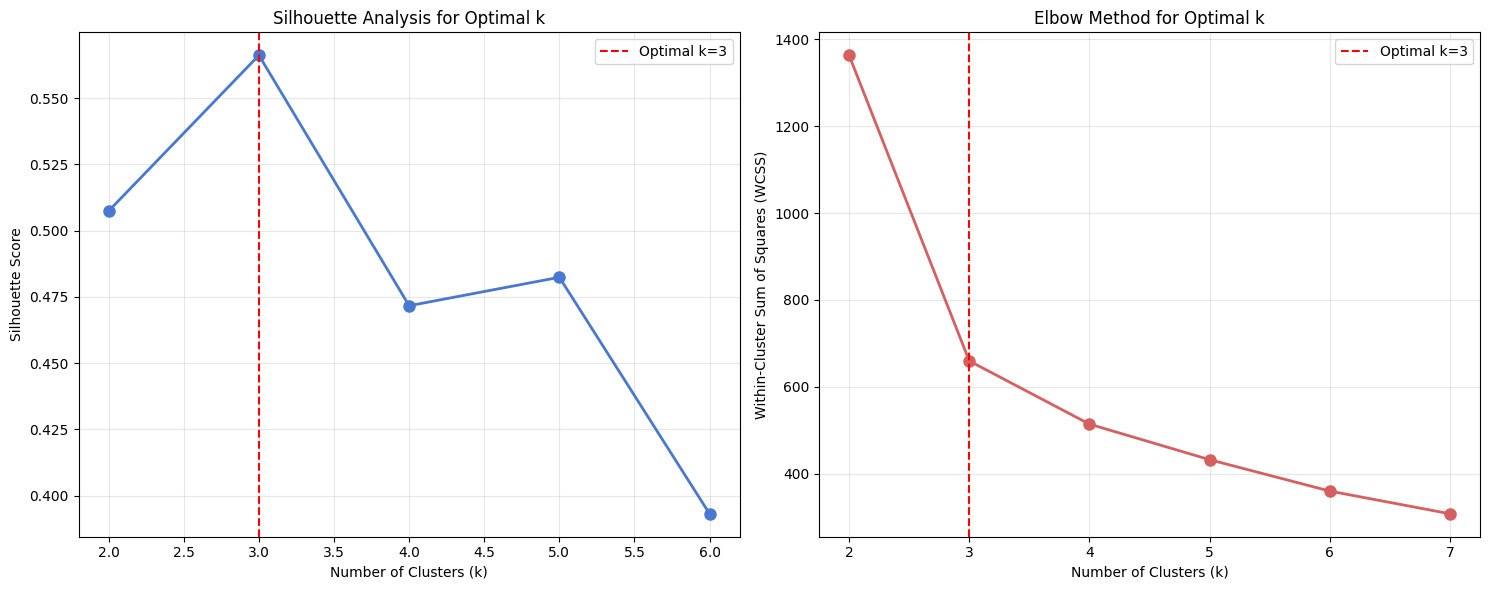

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

k_values = list(all_scores.keys())
silhouette_scores = list(all_scores.values())

ax1.plot(k_values, silhouette_scores, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Analysis for Optimal k')
ax1.grid(True, alpha=0.3)
ax1.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
ax1.legend()

inertias = []
k_range = range(2, min(8, len(X_scaled)))

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

ax2.plot(k_range, inertias, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
ax2.set_title('Elbow Method for Optimal k')
ax2.grid(True, alpha=0.3)
ax2.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
ax2.legend()

plt.tight_layout()
plt.show()

In [63]:
model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = model.fit_predict(X_scaled)

df_clustered = df_processed.copy()
df_clustered['cluster'] = cluster_labels

print(f"Number of clusters created: {optimal_k}")
print(f"Cluster distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"  Cluster {cluster}: {count} customers ({count/len(df_clustered)*100:.1f}%)")

print(f"\n=== CLUSTER CHARACTERISTICS ===")
cluster_analysis = df_clustered.groupby('cluster').agg({
    'recency': ['mean', 'median', 'std'],
    'frequency': ['mean', 'median', 'std'],
    'monetary': ['mean', 'median', 'std']
}).round(2)

print(cluster_analysis)

Number of clusters created: 3
Cluster distribution:
  Cluster 0: 434 customers (43.4%)
  Cluster 1: 407 customers (40.7%)
  Cluster 2: 159 customers (15.9%)

=== CLUSTER CHARACTERISTICS ===
        recency               frequency               monetary           \
           mean median    std      mean median    std     mean   median   
cluster                                                                   
0         32.83   24.0  30.28     18.74   16.0  11.38  4270.67  3898.03   
1         15.78   15.0   9.29      3.18    3.0   1.48   540.62   526.90   
2        258.27  272.0  64.55     15.03   15.0   6.17  4814.20  4938.09   

                  
             std  
cluster           
0        2206.95  
1         270.94  
2        1944.82  


In [64]:
def assign_segment_labels(df):
    cluster_stats = df.groupby('cluster').agg({
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': 'mean'
    })

    mapping = {}
    thresholds = {
        'recency': cluster_stats['recency'].median(),
        'frequency': cluster_stats['frequency'].median(),
        'monetary': cluster_stats['monetary'].median()
    }

    print("SEGMENTATION THRESHOLDS: ")
    print(f"Recency threshold: {thresholds['recency']:.1f} days")
    print(f"Frequency threshold: {thresholds['frequency']:.1f} orders")
    print(f"Monetary threshold: ${thresholds['monetary']:.2f}")

    for cluster_id, stats in cluster_stats.iterrows():
        recency_acceptable = stats['recency'] <= thresholds['recency']
        frequency_acceptable = stats['frequency'] >= thresholds['frequency']
        monetary_acceptable = stats['monetary'] >= thresholds['monetary']

        print(f"\nCluster {cluster_id}:")
        print(f"  Recency: {stats['recency']:.1f} ({'Acceptable' if recency_acceptable else 'Not Acceptable'})")
        print(f"  Frequency: {stats['frequency']:.1f} ({'Acceptable' if frequency_acceptable else 'Not Acceptable'})")
        print(f"  Monetary: ${stats['monetary']:.2f} ({'Acceptable' if monetary_acceptable else 'Not Acceptable'})")

        if recency_acceptable and frequency_acceptable and monetary_acceptable:
            mapping[cluster_id] = 'CHAMPION'
        elif frequency_acceptable and monetary_acceptable:
            mapping[cluster_id] = 'LOYAL'
        elif not recency_acceptable and (frequency_acceptable or monetary_acceptable):
            mapping[cluster_id] = 'AT_RISK'
        else:
            mapping[cluster_id] = 'NEW'

        print(f"  → Segment: {mapping[cluster_id]}")

    return mapping

In [65]:
segment_mapping = assign_segment_labels(df_clustered)
df_clustered['segment_label'] = df_clustered['cluster'].map(segment_mapping)

SEGMENTATION THRESHOLDS: 
Recency threshold: 32.8 days
Frequency threshold: 15.0 orders
Monetary threshold: $4270.67

Cluster 0:
  Recency: 32.8 (Acceptable)
  Frequency: 18.7 (Acceptable)
  Monetary: $4270.67 (Acceptable)
  → Segment: CHAMPION

Cluster 1:
  Recency: 15.8 (Acceptable)
  Frequency: 3.2 (Not Acceptable)
  Monetary: $540.62 (Not Acceptable)
  → Segment: NEW

Cluster 2:
  Recency: 258.3 (Not Acceptable)
  Frequency: 15.0 (Acceptable)
  Monetary: $4814.20 (Acceptable)
  → Segment: LOYAL


In [66]:
segment_distribution = df_clustered['segment_label'].value_counts()
for segment, count in segment_distribution.items():
    print(f"{segment}: {count} customers ({count/len(df_clustered)*100:.1f}%)")

CHAMPION: 434 customers (43.4%)
NEW: 407 customers (40.7%)
LOYAL: 159 customers (15.9%)


In [67]:
segment_stats = df_clustered.groupby('segment_label').agg({
    'recency': ['count', 'mean', 'median', 'std'],
    'frequency': ['mean', 'median', 'std'],
    'monetary': ['mean', 'median', 'std', 'sum']
}).round(2)

print(segment_stats)

              recency                       frequency               monetary  \
                count    mean median    std      mean median    std     mean   
segment_label                                                                  
CHAMPION          434   32.83   24.0  30.28     18.74   16.0  11.38  4270.67   
LOYAL             159  258.27  272.0  64.55     15.03   15.0   6.17  4814.20   
NEW               407   15.78   15.0   9.29      3.18    3.0   1.48   540.62   

                                             
                median      std         sum  
segment_label                                
CHAMPION       3898.03  2206.95  1853472.54  
LOYAL          4938.09  1944.82   765458.19  
NEW             526.90   270.94   220031.02  


In [68]:
print(f"\n=== BUSINESS IMPACT BY SEGMENT ===")
business_impact = df_clustered.groupby('segment_label').agg({
    'monetary': ['sum', 'mean'],
    'frequency': 'mean',
    'recency': 'mean'
}).round(2)

total_revenue = df_clustered['monetary'].sum()
business_impact['revenue_share'] = (business_impact['monetary']['sum'] / total_revenue * 100).round(1)
print("Revenue Share and Average Metrics by Segment:")
for segment in business_impact.index:
    total_rev = business_impact.loc[segment, ('monetary', 'sum')]
    avg_rev = business_impact.loc[segment, ('monetary', 'mean')]
    revenue_share = business_impact.loc[segment, 'revenue_share']
    avg_freq = business_impact.loc[segment, ('frequency', 'mean')]
    avg_rec = business_impact.loc[segment, ('recency', 'mean')]

    print(f"\n{segment}:")
    print(f"  Total Revenue: ${total_rev:,.2f} ({revenue_share}% of total)")
    print(f"  Avg Revenue per Customer: ${avg_rev:.2f}")
    print(f"  Avg Frequency: {avg_freq:.1f} orders")
    print(f"  Avg Recency: {avg_rec:.1f} days")


=== BUSINESS IMPACT BY SEGMENT ===
Revenue Share and Average Metrics by Segment:

CHAMPION:
  Total Revenue: $1,853,472.54 (    65.3
Name: CHAMPION, dtype: float64% of total)
  Avg Revenue per Customer: $4270.67
  Avg Frequency: 18.7 orders
  Avg Recency: 32.8 days

LOYAL:
  Total Revenue: $765,458.19 (    27.0
Name: LOYAL, dtype: float64% of total)
  Avg Revenue per Customer: $4814.20
  Avg Frequency: 15.0 orders
  Avg Recency: 258.3 days

NEW:
  Total Revenue: $220,031.02 (    7.8
Name: NEW, dtype: float64% of total)
  Avg Revenue per Customer: $540.62
  Avg Frequency: 3.2 orders
  Avg Recency: 15.8 days


C:\Users\ALEXANDER\AppData\Local\Temp\ipykernel_8808\1924664473.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




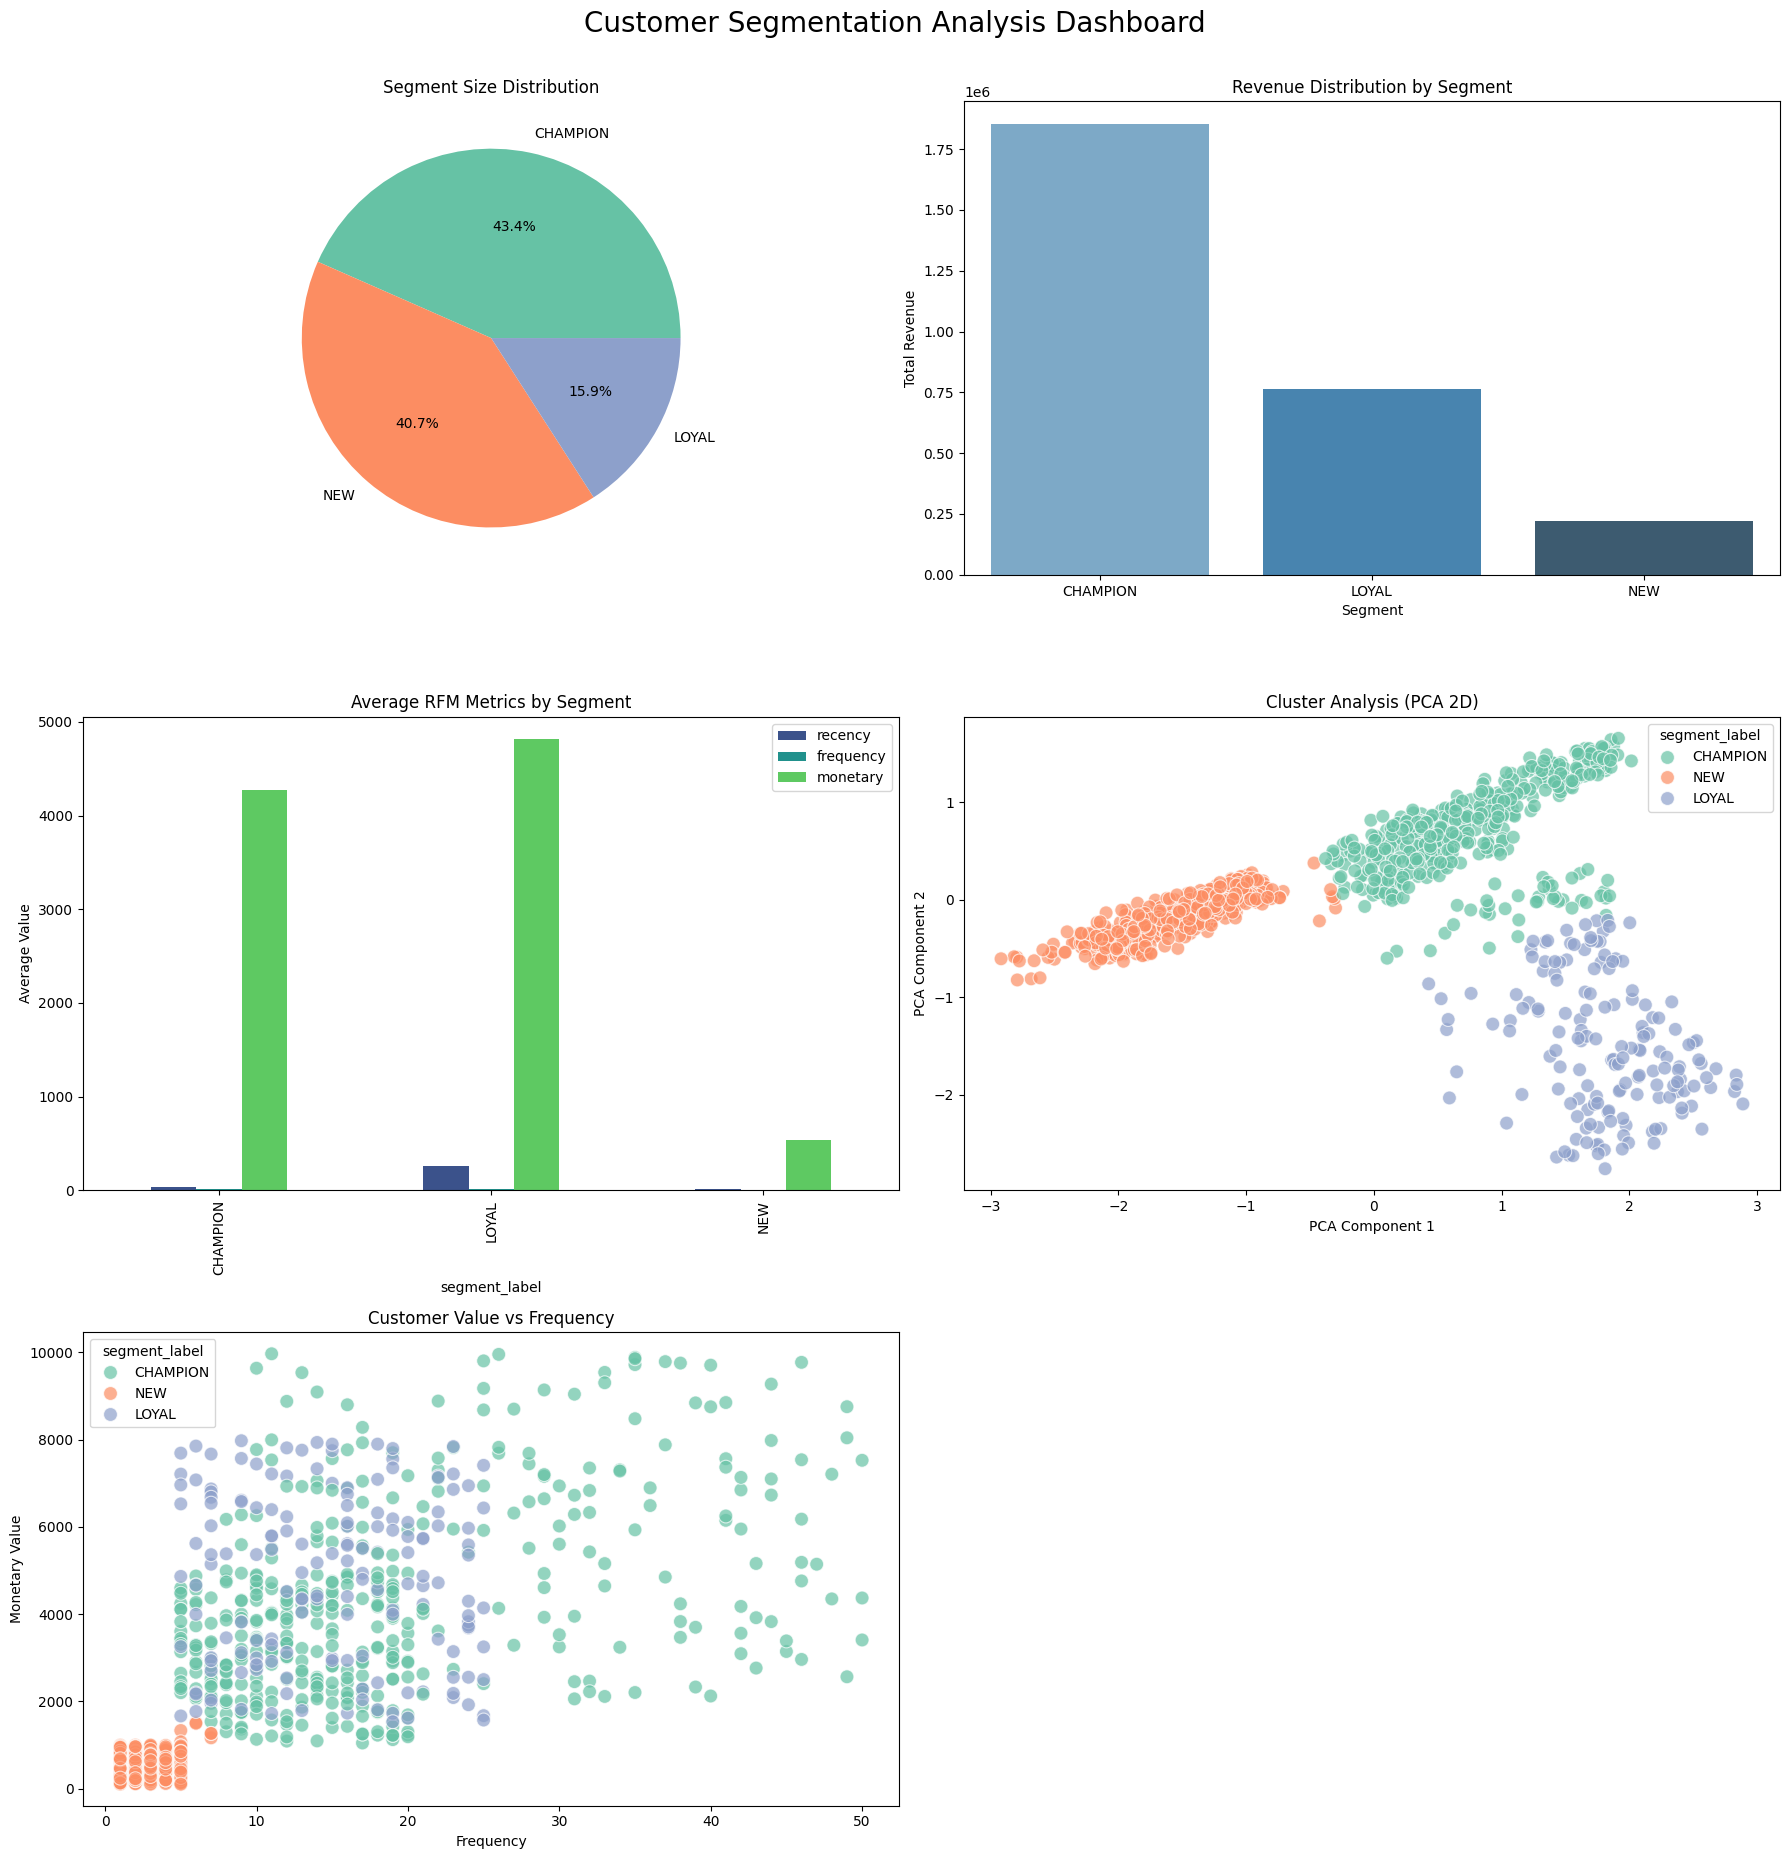

In [69]:
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

segment_counts = df_clustered['segment_label'].value_counts()
axes[0, 0].pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', colors=sns.color_palette("Set2", n_colors=len(segment_counts)))
axes[0, 0].set_title('Segment Size Distribution')

revenue_by_segment = df_clustered.groupby('segment_label')['monetary'].sum().sort_values(ascending=False)
sns.barplot(x=revenue_by_segment.index, y=revenue_by_segment.values, palette="Blues_d", ax=axes[0, 1])
axes[0, 1].set_title('Revenue Distribution by Segment')
axes[0, 1].set_xlabel('Segment')
axes[0, 1].set_ylabel('Total Revenue')

avg_metrics = df_clustered.groupby('segment_label')[['recency', 'frequency', 'monetary']].mean()
avg_metrics.plot(kind='bar', ax=axes[1, 0], color=sns.color_palette("viridis", n_colors=3))
axes[1, 0].set_title('Average RFM Metrics by Segment')
axes[1, 0].set_ylabel('Average Value')

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_clustered['segment_label'], palette="Set2", ax=axes[1, 1], s=100, alpha=0.7)
axes[1, 1].set_title('Cluster Analysis (PCA 2D)')
axes[1, 1].set_xlabel('PCA Component 1')
axes[1, 1].set_ylabel('PCA Component 2')

sns.scatterplot(data=df_clustered, x='frequency', y='monetary', hue='segment_label', palette="Set2", ax=axes[2, 0], s=100, alpha=0.7)
axes[2, 0].set_title('Customer Value vs Frequency')
axes[2, 0].set_xlabel('Frequency')
axes[2, 0].set_ylabel('Monetary Value')

fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.suptitle("Customer Segmentation Analysis Dashboard", fontsize=20, y=1.03)
plt.show()